In [93]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver,InMemorySaver

from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Annotated,Literal,List,Optional
from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
import operator
import json
import uuid

In [94]:

## Schema For Overall Features from the Story
class MangaFeatureSchema(BaseModel):
    main_characters: List[str] = Field(
        ..., description="List of main characters in the story, including roles or names."
    )
    
    character_descriptions: List[str] = Field(
        ..., description="Short descriptions of the characters’ traits, personalities, or roles."
    )
    
    setting: str = Field(
        ..., description="The primary setting or environment where the story takes place."
    )
    
    conflict_or_goal: str = Field(
        ..., description="The main conflict, tension, or goal driving the story."
    )
    
    important_objects: List[str] = Field(
        ..., description="Key objects, weapons, or magical items relevant to the story."
    )
    
    mood_and_tone: List[str] = Field(
        ..., description="Keywords describing the mood and tone of the story (normalized to lowercase)."
 )
    
    key_sound_effects_and_emotions: List[str] = Field(
        ..., description="Important sound effects (onomatopoeia) and strong emotions expressed in the story."
    )




### Schema for Character description
class CharacterProfile(BaseModel):
    name_or_role: str                 # e.g. "Curious Boy"
    canonical_name: Optional[str]     # e.g. "Taro" (or null)
    age_range: str                    # e.g. "early teens (13-15)"
    gender_presentation: Optional[str]# e.g. "male-presenting" or "non-binary"
    body_type: str                    # e.g. "slim, small frame"
    height: Optional[str]             # e.g. "short" or "170 cm"
    face: str                         # short face description: shape, nose, mouth
    hair: str                         # color, style, length
    eyes: str                         # color, shape, notable features
    clothing: str                     # typical outfit description
    accessories: List[str]            # e.g. ["rope belt", "necklace"]
    color_palette: List[str]          # hex or basic color names, ordered primary → accent
    notable_marks: List[str]          # scars, tattoos, birthmarks
    important_objects: List[str]      # items tied to the character, can be []
    signature_poses: List[str]        # short phrases e.g. ["hand-on-hilt", "heroic stance"]
    default_expressions: List[str]    # e.g. ["wide-eyed shock","determined glare"]
    voice_short: Optional[str]        # quick tonal note for dialogue (e.g. "soft, inquisitive")
    drawing_instructions: str         # manga-specific tips: line weight, shading, typical camera angle
    visual_reference_prompt: str      # 1-2 sentence short prompt formatted for image models
    consistency_token: str            # unique id you can pass to image-generator to keep same character

### For list of characters
class CharacterList(BaseModel):
    characters: List[CharacterProfile] = Field(..., description="List of character profiles"
    )




class SceneFeature(BaseModel):
    scene_number: int
    summary: str                                # 1–2 sentence summary
    setting_details: str                        # description of location, mood, time
    characters_involved: List[str]              # must match character_makeup entries
    actions: List[str]                          # short action phrases
    emotions: List[str]                         # emotional keywords
    potential_dialogues: List[str]              # "Name: text"
    inner_thoughts: List[str]                   # [inner thought style]
    sound_effects: List[str]                    # onomatopoeia list
    visual_elements: List[str]                   # Key visual cues, colors, lighting, objects, symbols

class SceneFeatureList(BaseModel):
    scenes: List[SceneFeature]


## Schema For Director
class Director_Panel(BaseModel):
    panel_number: int
    scene_description: str              # What is shown in the panel (setting, action, camera)
    characters_present: List[str]       # From character_setup
    actions: List[str]                  # Key actions happening in this panel
    dialogues: List[str]                # Short speech bubbles, "Name: text"
    inner_thoughts: List[str]           # If any, written as [thoughts]
    sound_effects: List[str]
    visual_elements: List[str] 
    

## Schema for Number of Pages

class MangaPage(BaseModel):
    page_number: int
    panels: List[Director_Panel]



# Schema for each generated image prompt per panel
class MangaImagePrompt(BaseModel):
    panel_number: int = Field(..., description="The panel number from the director script")
    image_prompt: str = Field(
        ..., 
        description="Short, clear description of what the image generation model should draw, including characters (with consistency_token), setting, action, emotions, camera angle, and sound effects"
    )

#  Schema for one manga page of generated prompts
class MangaImagePromptPage(BaseModel):
    page_number: int = Field(..., description="Page number in the manga")
    panel_prompts: List[MangaImagePrompt] = Field(
        ..., description="List of image prompts corresponding to panels on this page"
    )

# # Schema for multiple pages (if extend later)
# class MangaImagePromptBook(BaseModel):
#     pages: List[MangaImagePromptPage] = Field(
#         ..., description="List of pages, each with its panel image prompts"
#     )

In [95]:
_: bool = load_dotenv(find_dotenv())

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
structured_model_MangaFeature=model.with_structured_output(MangaFeatureSchema)
structured_model_characterList=model.with_structured_output(CharacterList)
structured_model_director=model.with_structured_output(MangaPage)
structured_model_scene=model.with_structured_output(SceneFeatureList)
structured_model_Mangaprompt=model.with_structured_output(MangaImagePromptPage)





In [96]:
class MangaState(TypedDict):
    input_story:str
    refined_story:str
    extracted_features:dict
    character_feature:dict
    scene_features:dict
    panel_scenes:dict
    manga_image_prompts:dict



In [97]:
def prompt_refinner(state:MangaState):
    user_story=state['input_story']
    prompt=f'''
            You are a professional manga storyteller. 
            Your job is to take a short user query and refine it into a concise manga-style story 
            suitable for ONE PAGE comic (4–6 sentences only).

            Requirements:
            - Keep the story short and dynamic (not more than 6 sentences).
            - Add manga-style elements: 
            * Dramatic emotions 
            * Exaggerated action or reactions 
            * Inner thoughts (marked with brackets [ ])
            * Sound effects (onomatopoeia like "BAM!", "WHOOSH!", "Gyaa!")
            - Story should feel like it can naturally be divided into 4–5 panels later.
            - Do not write panel breakdowns yet.

            User Query: {user_story}

            Refined Manga Story:
            '''
    refine_output=model.invoke(prompt).content
    return {"refined_story":refine_output}



def feature_extractor(state:MangaState):
    refine_story=state['refined_story']
    prompt=f"""

            You are a manga story analyzer. 
            Your task is to read the following refined manga story and extract its key features. 
            You MUST return the result as valid JSON that conforms to the MangaFeatureSchema below:

            Schema:
            {{
            "main_characters": ["list of character names or roles"],
            "character_descriptions": ["list of short character descriptions, same order as main_characters"],
            "setting": "short description of where the story takes place",
            "conflict_or_goal": "one-sentence summary of the story’s central conflict or goal",
            "important_objects": ["list of important items, weapons, or artifacts"],
            "mood_and_tone": ["one or more keywords: dramatic, mysterious, adventurous, romantic, comedic, emotional, dark"],
            "key_sound_effects_and_emotions": ["list of notable sound effects (onomatopoeia) and strong emotions"]
            }}

            Rules:
            - Only output valid JSON, no explanations.
            - Keep responses short and concise.
            - Ensure the JSON matches the schema exactly.

            Refined Manga Story:{refine_story}

        """
    output=structured_model_MangaFeature.invoke(prompt)

    return {"extracted_features":output.model_dump()}


def character_makeup(state: MangaState):
    refined_story = state['refined_story']
    extracted_feature = state['extracted_features']

    # extracted_feature could be a dict or a JSON string depending on prior step
    if isinstance(extracted_feature, dict):
        extracted_feature_json = extracted_feature
    elif isinstance(extracted_feature, str):
        try:
            extracted_feature_json = json.loads(extracted_feature)
        except Exception:
            extracted_feature_json = {"main_characters": [], "character_descriptions": []}
    else:
        extracted_feature_json = {}

    prompt = f'''
        You are a manga character designer. 
        Input: a short refined manga story and the extracted features (characters & brief descriptions).
        Your job: produce a JSON array "characters" of detailed, stable character profiles suitable for repeated drawing across multiple panels.
        You MUST output valid JSON ONLY and match the schema exactly.

        Schema (for each character):
        {{
        "name_or_role": "string",
        "canonical_name": "string or null",
        "age_range": "string",
        "gender_presentation": "string or null",
        "body_type": "string",
        "height": "string or null",
        "face": "short description (shape, nose, mouth, distinguishing facial features)",
        "hair": "short description (color, style, length)",
        "eyes": "short description (color, shape, special details like glow)",
        "clothing": "short description (top, bottom, shoes, texture)",
        "accessories": ["list of accessories"],
        "color_palette": ["primary", "secondary", "accent"],
        "notable_marks": ["scars, tattoos, birthmarks or empty list"],
        "important_objects": ["items associated with this character"],
        "signature_poses": ["list of 2-4 signature poses"],
        "default_expressions": ["list of 3 typical expressions used in manga"],
        "voice_short": "one-line descriptor of speaking voice or null",
        "drawing_instructions": "manga-specific tips (line weight, shading, preferred camera angles)",
        "visual_reference_prompt": "1-2 sentence prompt for an image generator to draw this character consistently",
        "consistency_token": "unique_short_token (use this in downstream image prompts to ensure consistency)"
        }}

        
        Rules:
        - You MUST create one character profile for every entry in "main_characters".
        - The number of profiles in "characters" must exactly equal the number of "main_characters".
        - Use the paired "character_descriptions" to enrich each profile.
        - If details are missing, infer them from the refined story.
        - Keep each profile short, clear, and usable for consistent drawing.
        - Output only valid JSON in the format: {{ "characters": [ ... ] }}

        Refined Story:
        {refined_story}

        Extracted Features:
        {json.dumps(extracted_feature_json)}

'''
    output = structured_model_characterList.invoke(prompt)
    return {"character_feature": output.model_dump()}


def scene_feature_extractor(state: MangaState):
    refined_story = state['refined_story']
    extracted_feature = state['extracted_features']
    characters = state['character_feature']

    # Normalize inputs
    if isinstance(extracted_feature, dict):
        features_json = extracted_feature
    else:
        try:
            features_json = json.loads(extracted_feature)
        except Exception:
            features_json = {}

    if isinstance(characters, dict):
        characters_json = characters
    else:
        try:
            characters_json = json.loads(characters)
        except Exception:
            characters_json = {}

    prompt = f"""
    You are a Manga Scene Director.  
    Input: a refined short manga story, extracted features, and character profiles.  
    Task: break the story into **4–5 sequential scenes** (not panels yet).  
    These scenes will later guide panel creation.  

    Output Schema (JSON only):
    {{
      "scenes": [
        {{
          "scene_number": 1,
          "summary": "1–2 sentence summary of what happens in this scene",
          "setting_details": "short description of location, mood, time",
          "characters_involved": ["names_or_roles"],
          "actions": ["list of short action phrases"],
          "emotions": ["keywords for emotional tone"],
          "potential_dialogues": ["list of possible dialogue lines (Name: text)"],
          "inner_thoughts": ["list of possible inner thoughts with [brackets]"],
          "sound_effects": ["list of onomatopoeia that could fit this scene"],
          "visual_elements": ["list of key visual cues, colors, lighting, objects, symbols"]
        }}
      ]
    }}

    Rules:
    - Always output 4 or 5 scenes. Never fewer.  
    - Each scene should feel like it could become one manga panel later.  
    - Use only characters from the character profiles.  
    - Keep dialogues short, natural, manga-style.  
    - Be consistent with story tone and features.  
    - Return **valid JSON only**.  

    Refined Story:
    {refined_story}

    Extracted Features:
    {json.dumps(features_json)}

    Character Profiles:
    {json.dumps(characters_json)}
    """

    output = structured_model_scene.invoke(prompt)
    return {"scene_features": output.model_dump()}


def manga_director(state: MangaState):
    refined_story = state['refined_story']
    features = state['extracted_features']
    characters = state['character_feature']
    scenes = state['scene_features']   # ✅ add this
    #scenes = state.get('scene_features') or state.get('scene_feature') or {}
    prompt = f"""
    You are a Manga Director. 
    Your job is to take the refined story, extracted features, character profiles, 
    and pre-extracted scene features, and create a ONE-PAGE manga script divided into **exactly 4–5 panels**.

    Schema:
    {{
      "page_number": 1,
      "panels": [
        {{
          "panel_number": 1,
          "scene_description": "string (describe scene, setting, mood, camera angle)",
          "characters_present": ["list of character names_or_roles"],
          "actions": ["short action phrases"],
          "dialogues": ["Name: text"],
          "inner_thoughts": ["list of inner thoughts if any"],
          "sound_effects": ["list of onomatopoeia like BAM, WHOOSH"],
          "visual_elements": ["list of key visual cues, colors, lighting, objects, symbols"]
        }}
      ]
    }}

    Rules:
    - Output **exactly 4 or 5 panels**. Never fewer, never more.
    - Each panel should map to one of the extracted "scenes" (use `scene_reference` field).
    - Use only characters from the given profiles.
    - Keep dialogues short, natural, manga-style.
    - Balance between action, emotion, and pacing.
    - Ensure JSON output only, no extra explanation.

    Refined Story: {refined_story}

    Extracted Features: {features}

    Character Profiles: {characters}

    Scene Features: {scenes}
    """

    output = structured_model_director.invoke(prompt)

    # Enforce 4–5 panels
    if "panels" in output and (len(output["panels"]) < 4 or len(output["panels"]) > 5):
        retry_prompt = prompt + "\n\n⚠️ Reminder: You must output 4–5 panels, not fewer, not more."
        output = structured_model_director.invoke(retry_prompt)

    return {"panel_scenes": output.model_dump()}





# def manga_comic_generator(state: MangaState):
#     refined_story = state["refined_story"]
#     features = state["extracted_feature"]
#     characters = state["character_feature"]
#     scenes = state["scene_features"]
#     panels = state["panel_scenes"]

#     prompt = f"""
#     You are an expert Manga Illustrator AI.
#     Your task is to generate **manga-style comic panels** based on the story, features, character designs, scene features, and director’s panel instructions.

#     # Global Rules for All Panels:
#     - Style: black-and-white manga, clean line art, screentone shading, dramatic lighting.
#     - Characters: must remain visually consistent using their "consistency_token" + "visual_reference_prompt".
#     - Each panel must be fully self-contained: repeat full character and background descriptions in every panel prompt, because images are generated independently.
#     - Backgrounds: keep recurring settings identical across panels by always describing them in the same way.
#     - Props/Clothing: must remain identical across all panels (e.g., same uniform, hairstyle, or objects) unless explicitly changed in the director’s script.
#     - Emotions: exaggerate expressions (wide eyes, sweat drops, speed lines, dramatic shadows).
#     - Sound Effects: always add manga-style onomatopoeia text when listed.
#     - Dialogues & Inner Thoughts: display exactly as provided in the script.
#     - Camera framing: always specify (e.g., "close-up", "wide shot", "medium shot").
#     - Always end each panel prompt with: "in consistent manga style".

#     # Inputs:
#     Refined Story:
#     {refined_story}

#     Extracted Features:
#     {json.dumps(features, indent=2)}

#     Character Profiles (use consistency_token and visual_reference_prompt for each character):
#     {json.dumps(characters, indent=2)}

#     Scene Features:
#     {json.dumps(scenes, indent=2)}

#     Director’s Panel Script:
#     {json.dumps(panels, indent=2)}

#     # Output Instruction:
#     For each panel in the Director’s Panel Script, generate an **image prompt** formatted as:

#     {{
#     "panel_number": <int>,
#     "image_prompt": "<1–3 sentences describing exactly what to draw: include characters with their 'consistency_token' and full 'visual_reference_prompt', poses, expressions, actions, identical setting description, camera angle, sound effects, and dialogues/inner thoughts. End with 'in consistent manga style'.>"
#     }}

#     Ensure:
#     - Each panel’s "image_prompt" is fully self-contained (do not use 'as previously described').
#     - Characters must always include their "consistency_token" and "visual_reference_prompt".
#     - Backgrounds and clothing must always be described consistently in the same wording.
#     - Include all dialogues and inner thoughts visually in the panel description.
#     - Use sound effects from the panel if listed.
#     - Only output valid JSON: a list of panel prompts.
#     """

#     return {"manga_image_prompts": structured_model_Mangaprompt.invoke(prompt)}




def manga_comic_generator(state: MangaState):
    refined_story = state["refined_story"]
    features = state["extracted_features"]
    characters = state["character_feature"]
    scenes = state["scene_features"]
    panels = state["panel_scenes"]

    prompt = f"""
    You are a Manga Illustrator AI.
    Generate compact **manga-style comic panel prompts** (≤70 tokens each).

    # Rules:
    - Style: black-and-white manga, clean line art, screentone shading.
    - Characters: always use their "consistency_token" + short visual keywords.
    - Backgrounds: keep consistent, describe in ≤5 words.
    - Panel prompt must be **1 short sentence**, keyword-style.
    - Always include: camera angle, characters, action, scene, emotions, sound, dialogue.
    - End each with "in consistent manga style".

    # Inputs:
    Refined Story:
    {refined_story}

    Extracted Features:
    {json.dumps(features, indent=2)}

    Character Profiles (use consistency_token and visual_reference_prompt for each character):
    {json.dumps(characters, indent=2)}

    Scene Features:
    {json.dumps(scenes, indent=2)}

    Director’s Panel Script:
    {json.dumps(panels, indent=2)}

    # Output Instruction:
    For each panel in the Director’s Panel Script, generate an **image prompt** formatted as:

    {{
    "panel_number": <int>,
    "image_prompt": "<1–3 sentences describing exactly what to draw: include characters with their 'consistency_token' and full 'visual_reference_prompt', poses, expressions, actions, identical setting description, camera angle, sound effects, and dialogues/inner thoughts. End with 'in consistent manga style'.>"
    }}

    Ensure:
    - Each panel’s "image_prompt" is fully self-contained (do not use 'as previously described').
    - Characters must always include their "consistency_token" and "visual_reference_prompt".
    - Backgrounds and clothing must always be described consistently in the same wording.
    - Include all dialogues and inner thoughts visually in the panel description.
    - Use sound effects from the panel if listed.
    - Only output valid JSON: a list of panel prompts.
    """

    return {"manga_image_prompts": structured_model_Mangaprompt.invoke(prompt).model_dump()}



In [98]:
# # Rules for Drawing:
# - Style: black-and-white manga style, with clean line art, screentone shading, and dramatic lighting.
# - Characters: must remain visually consistent across all panels using their "consistency_token" and "visual_reference_prompt".
# - Composition: follow the panel description (camera angle, action, emotion).
# - Emotions: exaggerate expressions (wide eyes, sweat drops, speed lines, dramatic shadows).
# - Sound Effects: integrate onomatopoeia text (e.g., "BAM!", "WHOOSH!") in stylized manga lettering.
# - Dialogues & Inner Thoughts: include all dialogues and inner thoughts from the director’s panel instructions.
# - Do not invent new characters or objects outside what’s provided.

In [99]:
# story=prompt_refinner({'input_story':"A boy name Ibad fall in love with a girl named Aisha."})
# features=feature_extractor({"refined_story":story})
# character_mkp=character_makeup({"refined_story": story["refined_story"], "extracted_features": features["extracted_feature"]})
# scenes_char=scene_feature_extractor({"refined_story": story["refined_story"], "extracted_feature": features["extracted_feature"],"character_feature": character_mkp["character_feature"]})


In [100]:
story='''
Ibad saw Aisha across the crowded schoolyard, and his heart *POW!* skipped a '
 "beat. [She's...an angel!] He clumsily rushed towards her, tripping over his "
 'own feet – *THUD!* Aisha giggled, her laughter like wind chimes. "H-hello!" '
 'Ibad stammered, face burning crimson. Aisha smiled, and Ibad knew, with '
 'absolute certainty, that his life had irrevocably changed. GYAa!')
'''
features=feature_extractor({"refined_story":story})
character_mkp=character_makeup({"refined_story": story, "extracted_features": features["extracted_features"]})
scenes_char=scene_feature_extractor({"refined_story": story, "extracted_feature": features["extracted_feature"],"character_feature": character_mkp["character_feature"]})


KeyError: 'extracted_feature'

In [ ]:
from pprint import pprint

pprint((scenes_char))


{'scene_features': SceneFeatureList(scenes=[SceneFeature(scene_number=1, summary='Ibad spots Aisha in the schoolyard and is immediately smitten.', setting_details='Crowded schoolyard, bright daylight, bustling with students.', characters_involved=['Ibad', 'Aisha'], actions=['Spotting someone', 'Rushing forward'], emotions=['Infatuation', 'Excitement', 'Anxiety'], potential_dialogues=[], inner_thoughts=["Ibad: She's...an angel!"], sound_effects=[], visual_elements=['Crowded schoolyard', 'Aisha in the distance', "Ibad's perspective"]), SceneFeature(scene_number=2, summary='Ibad trips while trying to reach Aisha.', setting_details="Same schoolyard, focusing on Ibad's clumsy movement.", characters_involved=['Ibad', 'Aisha'], actions=['Tripping', 'Falling'], emotions=['Embarrassment', 'Clumsiness'], potential_dialogues=[], inner_thoughts=[], sound_effects=['THUD!'], visual_elements=['Ibad tripping', 'Books scattering', 'Aisha noticing']), SceneFeature(scene_number=3, summary="Aisha laughs a

In [ ]:

pprint((features['extracted_feature']))

MangaFeatureSchema(main_characters=['Ibad', 'Aisha'], character_descriptions=['Clumsy, shy, in love', 'Kind, cheerful'], setting='Schoolyard', conflict_or_goal="Ibad tries to win Aisha's heart.", important_objects=[], mood_and_tone=['romantic', 'comedic', 'emotional'], key_sound_effects_and_emotions=['POW!', 'THUD!', 'GYAa!', 'laughter'])


In [ ]:

pprint((character_mkp['character_feature']))

CharacterList(characters=[CharacterProfile(name_or_role='Ibad', canonical_name='Ibad', age_range='Teenager', gender_presentation='Male', body_type='Slim', height='Average', face='Round face, nervous smile, slight blush', hair='Short, messy black hair', eyes='Large, brown, expressive eyes', clothing='School uniform, slightly rumpled', accessories=[], color_palette=['Black', 'White', 'Red'], notable_marks=[], important_objects=[], signature_poses=['Tripping', 'Stammering', 'Blushing'], default_expressions=['Nervous', 'Excited', 'Embarrassed'], voice_short='High-pitched, easily flustered', drawing_instructions='Use thin lines for nervousness, emphasize blush with hatching', visual_reference_prompt='A teenage boy with short black hair and large brown eyes, wearing a school uniform, looking flustered and tripping.', consistency_token='ibad_001'), CharacterProfile(name_or_role='Aisha', canonical_name='Aisha', age_range='Teenager', gender_presentation='Female', body_type='Slender', height='Av

In [ ]:
# director=manga_director({
#     "refined_story": story["refined_story"], 
#     "extracted_feature": features["extracted_feature"],
#     "character_feature": character_mkp["character_feature"],
#     "scene_features":scenes_char["scene_features"]
# })

In [ ]:
director=manga_director({
    "refined_story": story, 
    "extracted_feature": features["extracted_feature"],
    "character_feature": character_mkp["character_feature"],
    "scene_features":scenes_char["scene_features"]
})

In [101]:
manga_comic_generator({
    "refined_story": story,
    "extracted_feature": features["extracted_feature"].model_dump(),
    "character_feature": character_mkp["character_feature"].model_dump(),
    "scene_features": scenes_char["scene_features"].model_dump(),
    "panel_scenes": director["panel_scenes"].model_dump()
})

KeyError: 'extracted_feature'

In [102]:
##Creating Graph

graph=StateGraph(MangaState)

## creating Nodes

graph.add_node("prompt_refinner",prompt_refinner)
graph.add_node("feature_extractor",feature_extractor)
graph.add_node("character_makeup",character_makeup)
graph.add_node("scene_feature_extractor", scene_feature_extractor) 
graph.add_node("manga_director",manga_director)
graph.add_node("manga_comic_generator",manga_comic_generator)


#Creating Edges

graph.add_edge(START,"prompt_refinner")
graph.add_edge("prompt_refinner","feature_extractor")
graph.add_edge("feature_extractor","character_makeup")
graph.add_edge("character_makeup","scene_feature_extractor")
graph.add_edge("scene_feature_extractor","manga_director")
graph.add_edge("manga_director","manga_comic_generator")
graph.add_edge("manga_comic_generator",END)

#checkpointer=InMemorySaver()

workflow=graph.compile()

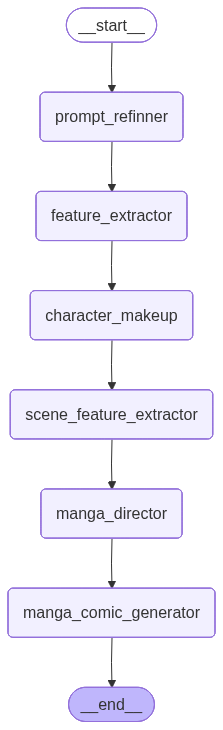

In [103]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [104]:
intial_state = {'input_story':"A boy name Ibad fall in love with a girl named Aisha."}

final_state = workflow.invoke(intial_state)

print(final_state)

{'input_story': 'A boy name Ibad fall in love with a girl named Aisha.', 'refined_story': 'Ibad saw Aisha across the crowded schoolyard, [Her smile...it\'s blinding!]. *BA-DUMP!* His heart hammered against his ribs – love at first sight! He clumsily approached, tripping over his own feet, *THUD*. Aisha giggled, extending a hand to help him up. "I\'m Aisha," she said, her voice like music, and Ibad knew he was a goner – *KYAA!* – this was it, his shoujo manga moment!', 'extracted_features': {'main_characters': ['Ibad', 'Aisha'], 'character_descriptions': ['Shy, clumsy boy experiencing love at first sight', 'Friendly girl with a beautiful smile'], 'setting': 'Crowded schoolyard', 'conflict_or_goal': 'Ibad tries to overcome his shyness to connect with Aisha after falling in love at first sight.', 'important_objects': [], 'mood_and_tone': ['romantic', 'comedic', 'emotional'], 'key_sound_effects_and_emotions': ['BA-DUMP!', 'THUD', 'KYAA!']}, 'character_feature': {'characters': [{'name_or_ro

In [105]:
final_state["manga_image_prompts"]

{'page_number': 1,
 'panel_prompts': [{'panel_number': 1,
   'image_prompt': 'Wide shot, crowded schoolyard, ibad_001 "Draw a shy, clumsy teenage boy with messy brown hair and large, expressive eyes. He is wearing a school uniform and looks flustered." sees aisha_002 "Draw a friendly teenage girl with long black hair and a radiant smile. She is wearing a school uniform and has a kind, approachable demeanor." across the yard; Ibad stares dreamily, thinks [Her smile...it\'s blinding!]; sunlight streams through, soft focus on Aisha in consistent manga style.'},
  {'panel_number': 2,
   'image_prompt': 'Close-up on ibad_001 "Draw a shy, clumsy teenage boy with messy brown hair and large, expressive eyes. He is wearing a school uniform and looks flustered."\'s sweating face, schoolyard background; heart pounds, BA-DUMP! sound effect, thinks [I have to talk to her!] in consistent manga style.'},
  {'panel_number': 3,
   'image_prompt': 'Schoolyard background, ibad_001 "Draw a shy, clumsy tee